In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

#custom Kothadekh
from data_dataloader import get_loaders
from data_dekhabet import convertTokens2Dekhabet
from Dataset_Control_Toolset import ModelMonitor 

# Bi-LSTM Component

In [12]:
#Bi-LSTM borrowed fom https://github.com/meijieru/crnn.pytorch/blob/master/models/crnn.py
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

# R-CNN Component

In [13]:
class R_CNN(nn.Module):

    def __init__(self, train=True):
        super(R_CNN, self).__init__()

        in_nc = 3
        nf = 64
        hdn = 256
        nclass = 22 #dekhabet class
        
        
        # custom vesion of the CNN poposed 
        # here: https://arxiv.org/pdf/1507.05717.pdf
        self.convs = nn.Sequential(
            
            nn.Conv2d(in_nc, nf, 3, 1, 1),                                                                                                                 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d(2, 2), #64 filters, 64*128
            
            nn.Conv2d(nf, nf*2, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d(2,2), #128 filters, 32*64
            
            nn.Conv2d(nf*2, nf*4, 3, 1, 1), 
            nn.BatchNorm2d(nf*4),
            
            nn.Conv2d(nf*4, nf*4, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2,1),(2,1)), #256 filters, 16*32
            
            
            nn.Conv2d(nf*4, nf*4, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((1,21),(2,1)),
            
            
            nn.Conv2d(nf*4, nf*8, 3, 1, 1), 
            nn.BatchNorm2d(nf*8),
            
            
            nn.Conv2d(nf*8, nf*8, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2,1),(2,1)),
            
            
            nn.Conv2d(nf*8, nf*8, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 1),(2,1)),  
            
            nn.Conv2d(nf*8, nf*8, 2, 1,0), 
            
            
        )
        
        self.bilstm = nn.Sequential(
                        BidirectionalLSTM(nf*8, hdn, hdn),
                        BidirectionalLSTM(hdn, hdn, nclass),
                    )
        
        self.lgsftMx = nn.LogSoftmax(dim=2)
        self.sftMx = nn.Softmax(dim=2)
        
    def forward(self, x):

        out = self.convs(x)
        out = out.squeeze(2)
        out = out.permute(2, 0, 1) #ctc expects [width,batch,label]
        
        
        out = self.bilstm(out)
        
        if(self.train):
            out = self.lgsftMx(out)
        else:
            out = self.sftMx(out)
            
        
        
        return out


# Initiate Model And Loss

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = R_CNN()
model = model.to(device)

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True).to(device)


# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)


cuda:0


In [15]:
import torch 

print(torch.__version__)

1.2.0+cu92


# Getting The Data

In [16]:
batch_size= 25

# path = '2k2sec_22class'
# rpath = 'data/numpy_arrays/22_class/'

path = '2k2sec'
rpath = 'data/numpy_arrays/22_class_fc/'



trainloader, validloader = get_loaders(path,split_perc=0.8,batch_size=batch_size,rootpath=rpath)

total_step = len(trainloader)

trainiter = iter(trainloader)

# images_t, labels_t, lens = trainiter.next()

# print(len(trainloader))
# print(labels_t.shape)
# print(lens.shape)


2000 images from the dataset
1600 400


# Training

In [25]:
ctc_loss_list = []
acc_list = []

num_epochs = 1500


In [26]:
batch_size= 25

# path = '2k2sec_22class'
# rpath = 'data/numpy_arrays/22_class/'

# path = '2k2sec43trtst'
# rpath = 'data/numpy_arrays/22_class_43sec_fixed/'

path = '2k2sec'
rpath = 'data/numpy_arrays/22_class_nospace/'

trainloader, validloader = get_loaders(path,split_perc=0.8,batch_size=batch_size,rootpath=rpath)

total_step = len(trainloader)

trainiter = iter(trainloader)

# images_t, labels_t, lens = trainiter.next()

# print(len(trainloader))
# print(labels_t.shape)
# print(lens.shape)


2000 images from the dataset
1600 400


In [24]:
for epoch in range(num_epochs):
    
    trainiter = iter(trainloader)
    
    for i in range(total_step-1):
        
        spectros, lbls, lbl_lens = trainiter.next()
        
        print(lbls)
        
        spectros = spectros.to(device)
        
        
        
        lbls = lbls.to(device)
        lbl_lens.to(device)
        
        pred = model(spectros)
        
        print(pred.shape)
        print(spectros.shape)
        
        preds_size = Variable(torch.LongTensor([pred.size(0)] * batch_size))
        
        print(preds_size)
        print(lbls.shape)
        print(lbls[0])
        
        break
    
    break
#         #backprop and optimize!
        
        
#         optimizer.zero_grad()
#         cost = criterion(pred, lbls, preds_size, lbl_lens)/batch_size

#         cost.backward()
#         optimizer.step()

tensor([[ 4, 16,  9,  ...,  0,  0,  0],
        [18,  4, 15,  ...,  0,  0,  0],
        [ 1, 14,  3,  ...,  0,  0,  0],
        ...,
        [21,  2, 11,  ...,  0,  0,  0],
        [ 9,  1, 17,  ...,  0,  0,  0],
        [21,  4, 15,  ...,  0,  0,  0]])
torch.Size([43, 25, 22])
torch.Size([25, 3, 128, 256])
tensor([43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43])
torch.Size([25, 43])
tensor([ 4, 16,  9,  2, 15, 17,  8,  2,  6,  2, 17,  5, 11,  1,  1, 20,  9,  2,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], device='cuda:0')


In [27]:
for epoch in range(num_epochs):
    
    trainiter = iter(trainloader)
    
    for i in range(total_step-1):
        
        spectros, lbls, lbl_lens = trainiter.next()
        
        spectros = spectros.to(device)
        
        lbls = lbls.to(device)
        lbl_lens.to(device)
        
        pred = model(spectros)
        preds_size = Variable(torch.LongTensor([pred.size(0)] * batch_size))
        
        #backprop and optimize!
        
        
        optimizer.zero_grad()
        cost = criterion(pred, lbls, preds_size, lbl_lens)/batch_size

        cost.backward()
        optimizer.step()
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}]  {:.4f}'.format(epoch+1,num_epochs,cost.item()))
        ctc_loss_list.append(cost.item())

    if (epoch+1) % 100 == 0:
        print('Epoch No {}  reached saving model'.format(epoch+1))
        torch.save(model.state_dict(), 'outputModel/KDNet_epoch_rmsProp_{}_noZerolenfixed.pkl'.format(epoch+1))

Epoch No [10/1500]  0.1093
Epoch No [20/1500]  0.0966
Epoch No [30/1500]  0.0788
Epoch No [40/1500]  0.0672
Epoch No [50/1500]  0.0507
Epoch No [60/1500]  0.0378
Epoch No [70/1500]  0.0299
Epoch No [80/1500]  0.0241
Epoch No [90/1500]  0.0110
Epoch No [100/1500]  0.0073
Epoch No 100  reached saving model
Epoch No [110/1500]  0.0064
Epoch No [120/1500]  0.0039
Epoch No [130/1500]  0.0045
Epoch No [140/1500]  0.0080
Epoch No [150/1500]  0.0805
Epoch No [160/1500]  0.0015
Epoch No [170/1500]  0.0030
Epoch No [180/1500]  0.0011
Epoch No [190/1500]  0.0017
Epoch No [200/1500]  0.0014
Epoch No 200  reached saving model
Epoch No [210/1500]  0.0029


KeyboardInterrupt: 

# Running Inference

In [28]:
inferModel = R_CNN()
inferModel.load_state_dict(torch.load('outputModel/KDNet_epoch_rmsProp_200_noZerolenfixed.pkl'))
inferModel.to(device)

R_CNN(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): MaxPool2d(ke

In [29]:
testIter = iter(validloader)


In [30]:
spectros, lbls, lbl_lens = testIter.next()

spectros = spectros.to(device)
lbls = lbls.to(device)
lbl_lens.to(device)



preds = inferModel(spectros)
_, preds = preds.max(2)
preds = preds.transpose(1, 0)




print(preds)
print(lbls)

pred_list = preds.transpose(1, 0).contiguous().view(-1)

lbls_list = lbls.contiguous().view(-1)



tensor([[21, 21,  4,  ...,  9,  1,  1],
        [ 2,  2,  2,  ...,  2,  2,  2],
        [ 9,  1,  1,  ...,  2,  2,  2],
        ...,
        [ 8,  5,  5,  ..., 13, 13,  4],
        [ 1,  1,  3,  ...,  1,  1,  1],
        [ 4,  4,  4,  ...,  2, 15,  1]], device='cuda:0')
tensor([[21,  5,  8,  ...,  0,  0,  0],
        [ 8,  2,  6,  ...,  0,  0,  0],
        [ 9,  1, 11,  ...,  0,  0,  0],
        ...,
        [12,  5,  8,  ...,  0,  0,  0],
        [ 1, 16,  3,  ...,  0,  0,  0],
        [ 4, 11,  4,  ...,  0,  0,  0]], device='cuda:0')


In [31]:
print('Our prediction labels: ')

for sent in preds:
    print(convertTokens2Dekhabet(sent))


print('\n\nBelow is the Actual labels: ')
    
    
for sent in lbls:
    print(convertTokens2Dekhabet(sent))

Our prediction labels: 
shshoo       thhhottttaajjhaaiijaaach  chhhhhaa
eee   duuh   nnndkkkkk eboaaaaaaa  chchchhheee
haaa         kkkkhhaaaaahaaaatttaaaachhhheee
toon kkonnnbhii chchchchteeee oheeeotttthhakeee
toomdeeedaatt  shshshshshshaaeeeeeee  oooeeereeei
eee tttttaortttttteeegggg  lledddd       mng
ssaar laiii ari    eeee  haaajaa      chchhhe
biiii    bkoooook  pppppookkkiii        iii
eeekkoooooouiiishshooooobbbiiii ttaoo  tttkii
eeebhhaabe   shshshokk aaatheaatettaajjjjabena
kaarroaee    kkootkkobbolllooooooch eeshshshshshi
hhaa                                       
toolii bboeett eekkkii  oooshshshshshsheammnooooo
shoo     chhooo oooo  eeeeoobbrrches aakkeennn
eee toooreee   lee   tttt iinitt  shshshshshshonn
amm    oubbbe  oooottteeppprrr   chchhhhinnaa
shuon   shshuuuuuuuuuuuchchchooochhhhuloochchchhhlnno
tuiiiii booli pooorriiigeei ttteeeehhoobbee
kiii    chchchoeiii                      j    
saarraaaar        aannnr    ssssh    mmnnnn
oou    ktttthhhaabbbblool    chchc

# Validation Inference

# Accuracy Calc

RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

[0.09000084549188614, 0.07625780999660492, 0.0655377209186554, 0.05417175218462944, 0.0400012731552124, 0.03169669583439827, 0.019887564703822136, 0.015111340209841728, 0.009061044082045555, 0.001064698095433414, -0.00222728680819273, -0.006760750897228718, -0.010586680844426155, -0.010537346825003624, -0.012609896250069141, -0.012112515047192574, -0.01246198732405901, -0.007762361783534288, 0.0012915232218801975, -0.013916783966124058, -0.013202349655330181, -0.01320709753781557, -0.013348155654966831, -0.009126282297074795, -0.014206389896571636, -0.014673130586743355, -0.014609130099415779, -0.006138745229691267, -0.014277645386755466, -0.014057325199246407, -0.014878669753670692, -0.014372444711625576, -0.007953837513923645, -0.014409922994673252, -0.014957373030483723, -0.009517459198832512, -0.01471664384007454, -0.013901080936193466, -0.013175081461668015, -0.012637636624276638, -0.014682087115943432, -0.013832311145961285, -0.014915595762431622, -0.014593124389648438, -0.014929

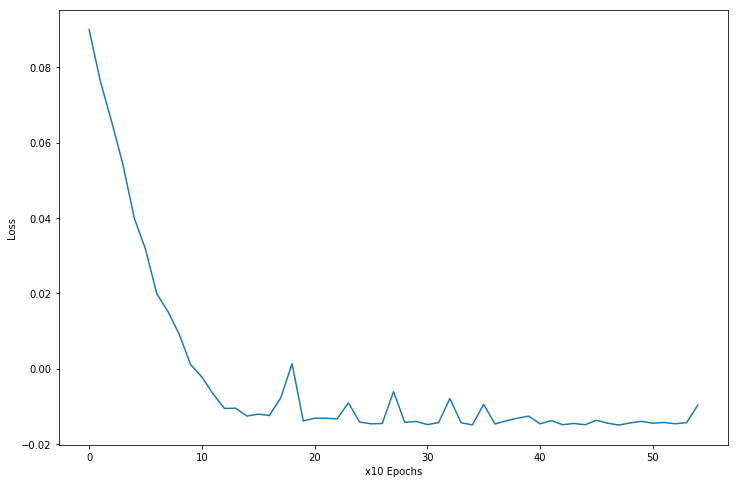

In [29]:
lst = [0.0903, 0.0724, 0.0591, 0.0464, 0.0381, 0.0254, 0.0180, 0.0155,0.0060,0.0036,0.0009]


plt.figure(figsize=[12,8])


plt.ylabel('Loss')
plt.xlabel('x10 Epochs')

plt.plot(ctc_loss_list)

print(ctc_loss_list)